In [1]:
import random
import numpy as np
import cv2
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, LSTM, Dense, Flatten, TimeDistributed

In [2]:
size = 30

In [11]:
# generate the next frame in the sequence

def next_frame(last_step, column, size):
    frame = np.zeros((size, size))
    # define the scope of the next step
    lower = max(0, last_step - 3)
    upper = min(frame.shape[0] - 1, last_step + 3)
    # choose the row index for the next step
    step = random.randint(lower, upper)
    # add the new step
    cv2.circle(frame, (column, step), 3, 255, -1)
    # frame[step, column] = 1
    return frame, step

In [12]:
# generate a suggestion of frames of a dot moving across an image

def build_frames(size):
    frames = list()
    
    step = random.randint(0, size - 1)
    # decide if we are heading left or right
    right = 1 if random.random() < 0.5 else 0
    col = 0 if right else size - 1
    
    # create all frames
    for i in range(0, size):
        col = i if right else size - 1 - i
        frame, step = next_frame(step, col, size)
        frames.append(frame)
    return frames, right

In [13]:
# generate multiple sequences of frames and reshape for network input

def generate_examples(size, n_patterns):
    X, y = list(), list()
    for _ in range(n_patterns):
        frames, right = build_frames(size)
        X.append(frames)
        y.append(right)
        
    # resize as [samples, timesteps, width, height, channels]
    X = np.array(X).reshape(n_patterns, size, size, size, 1)
    y = np.array(y).reshape(n_patterns, 1)
    return X, y

<-- Left


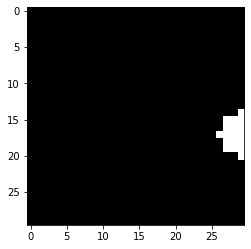

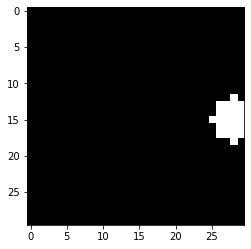

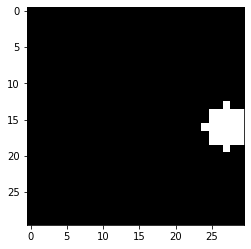

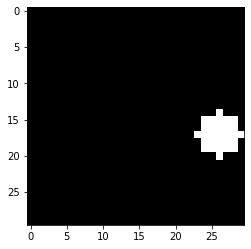

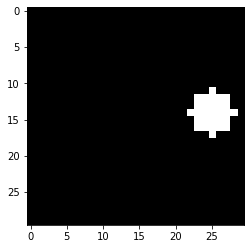

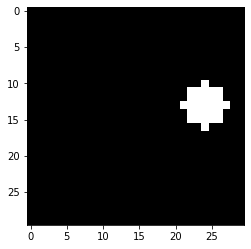

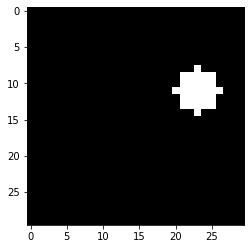

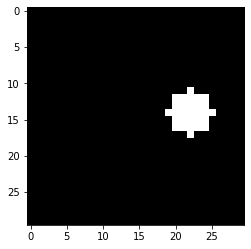

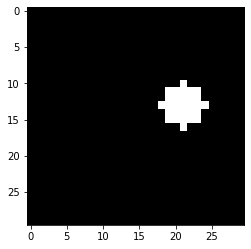

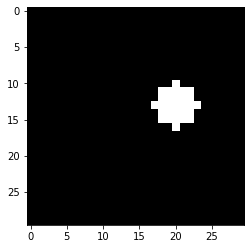

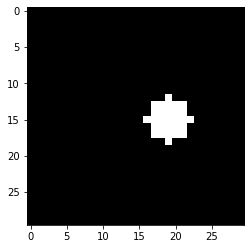

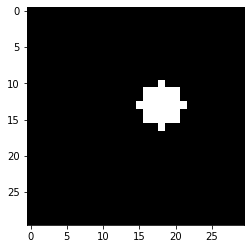

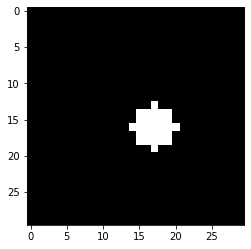

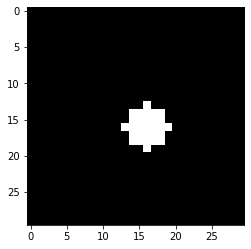

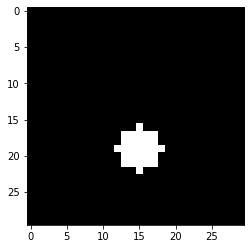

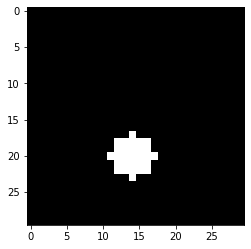

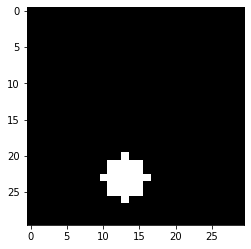

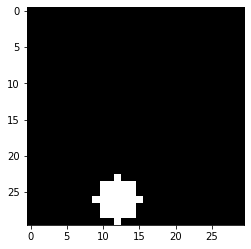

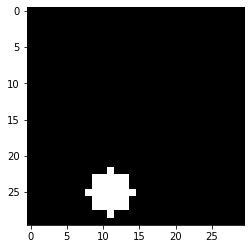

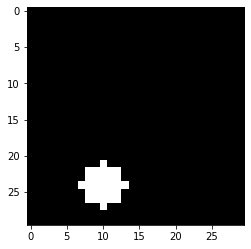

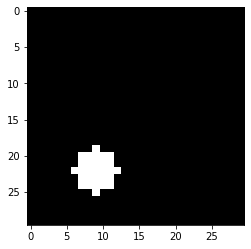

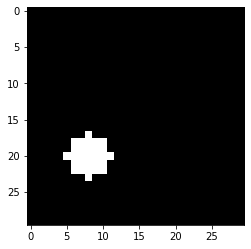

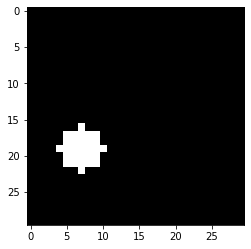

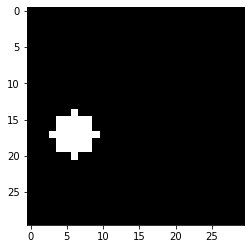

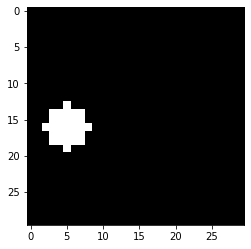

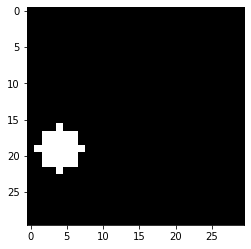

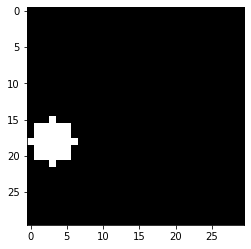

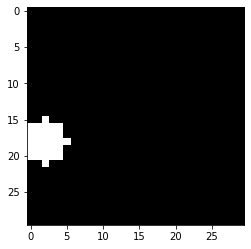

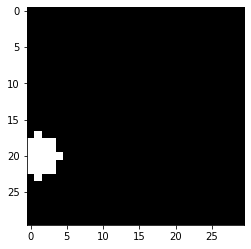

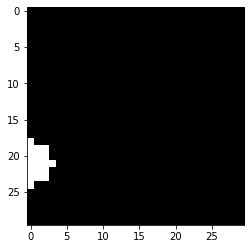

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline

X, Y = generate_examples(size, 1)
print("Right -->") if Y[0] else print("<-- Left")

for frame in X[0]:
    plt.imshow(frame[:,:,0], cmap="gray")
    plt.show()

In [16]:
# define the model

model = Sequential()
model.add(TimeDistributed(Conv2D(2, (3,3), activation='relu'),
                         input_shape= (None, size, size, 1)))
model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))
model.add(TimeDistributed(Flatten()))
model.add(LSTM(50))
model.add(Dense(1, activation='sigmoid'))
print(model.summary())


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_1 (TimeDist (None, None, 28, 28, 2)   20        
_________________________________________________________________
time_distributed_2 (TimeDist (None, None, 14, 14, 2)   0         
_________________________________________________________________
time_distributed_3 (TimeDist (None, None, 392)         0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 50)                88600     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
Total params: 88,671
Trainable params: 88,671
Non-trainable params: 0
_________________________________________________________________
None


In [17]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [19]:
# fit model
X, y = generate_examples(size, 1000)
model.fit(X, y, batch_size = 32, epochs = 1)


Epoch 1/1
1000/1000 [==============================] - 6s 6ms/step - loss: 0.2649 - acc: 0.9440


In [20]:
# Evaluate model
X, y = generate_examples(size, 100)
loss, acc = model.evaluate(X, y, verbose=0)
print('loss: %f, acc: %f' % (loss, acc * 100))

loss: 0.084745, acc: 100.000000


In [21]:
# Prediction on new data
X, y = generate_examples(size, 1)
yhat = model.predict_classes(X, verbose=0)
expected = "right" if y[0] == 1 else "Left"
predicted = "Right" if yhat[0] == 1 else "Left"
print('Expected: %s, Predicted: %s' % (expected, predicted))

Expected: Left, Predicted: Left
